## Train time estimate 

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import time
import copy
import torch
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader 

from nu_smrutils import load_pooled, loaddat, get_data_loaders, train_time 
from nu_smrutils import CNN2D

In [2]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if dev.type == 'cuda':
   print('Your GPU device name :', torch.cuda.get_device_name())        
else:
   print('No GPU Available :', dev)

Your GPU device name : GeForce GTX 1050 Ti


In [3]:
dname = dict(BNCI2014004 = 'aBNCI2014004R.pickle',
             BNCI2014001 = 'aBNCI2014001R.pickle',
             Weibo2014   = 'aWeibo2014R.pickle',
             Physionet   = 'aPhysionetRR.pickle')

In [8]:
num_epochs = 150 
learning_rate = 1e-3
weight_decay = 1e-4  
batch_size = 64
verbose = 2

fs = 80
# define kernel size in terms of ms length 
time_window = 100 #ms
width = time_window*fs//1000    

# ker = 8 #timelength//chans 
h, w = 3, 1  #hight and width of a rectangular kernel      

# kernel size 
kernel_size = [(h, w*width), (h, w*width), (h, w*width), (h, w*width),
               (h, w*width), (h, w*width), (h, w*width), (h, w*width)]

conv_chan   = [1, 128, 64, 32, 16, 8]                     

In [ ]:
# itenu_smrutilsis one of : ['BNCI2014004', 'BNCI2014001', 'Weibo2014', 'Physionet']
#itemname = 'BNCI2014004'
#filename = dname[itemname]
#iname    = itemname + '__'    
### Load pooled EEG data
#- the pooled data represents a set of combined subject-specific EEG data
alldat = dict()

for ii, itemname in enumerate(dname.keys()):

    data = loaddat(dname[itemname])
    
    subjectIndex = list(range(108))
    class_name = ['left_hand', 'right_hand']
    
    datp = load_pooled(data, subjectIndex, class_name, normalize = True, test_size = 0.15)
    dat  = get_data_loaders(datp, batch_size = 64)
    
    input_size = (1, dat['test_data']['x_test'].shape[-2], 
                     dat['test_data']['x_test'].shape[-1])

    # Define the architecture
    model = CNN2D(input_size    = input_size, 
                  kernel_size   = kernel_size, 
                  conv_channels = conv_chan, 
                  dense_size    = 256, 
                  dropout       = 0.5)   
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = torch.nn.CrossEntropyLoss()

    model.to(dev)  
    criterion.to(dev)       
   
    ttime = train_time(model, dat['dset_loaders'], dat['dset_sizes'],
                       criterion, optimizer, dev, num_epochs = num_epochs)
    
    alldat[itemname] = ttime 


Input data shape torch.Size([4433, 1, 3, 321])
Input shape and flattened out torch.Size([1, 128, 3, 161]) 61824
Input shape and flattened out torch.Size([1, 64, 3, 81]) 15552
Input shape and flattened out torch.Size([1, 32, 3, 41]) 3936
Input shape and flattened out torch.Size([1, 16, 3, 21]) 1008
Input shape and flattened out torch.Size([1, 8, 3, 11]) 264
Epoch 1/150
Epoch 2/150
Epoch 3/150
Epoch 4/150
Epoch 5/150
Epoch 6/150
Epoch 7/150
Epoch 8/150
Epoch 9/150
Epoch 10/150
Epoch 11/150
Epoch 12/150
Epoch 13/150
Epoch 14/150
Epoch 15/150
Epoch 16/150
Epoch 17/150
Epoch 18/150
Epoch 19/150
Epoch 20/150
Epoch 21/150
Epoch 22/150
Epoch 23/150
Epoch 24/150
Epoch 25/150
Epoch 26/150
Epoch 27/150
Epoch 28/150
Epoch 29/150
Epoch 30/150
Epoch 31/150
Epoch 32/150
Epoch 33/150
Epoch 34/150
Epoch 35/150
Epoch 36/150
Epoch 37/150
Epoch 38/150
Epoch 39/150
Epoch 40/150
Epoch 41/150
Epoch 42/150
Epoch 43/150
Epoch 44/150
Epoch 45/150
Epoch 46/150
Epoch 47/150
Epoch 48/150
Epoch 49/150
Epoch 50/150


In [103]:
ttime.keys()

dict_keys(['filename', 'time_elapsed_epoch', 'time_elapsed_batch', 'total_time_elapsed'])

In [104]:
traintime = ttime

In [105]:
traintime.keys()

dict_keys(['filename', 'time_elapsed_epoch', 'time_elapsed_batch', 'total_time_elapsed'])

In [106]:
len(time_elapsed_epoch)

time_elapsed_epoch[0]
total_time_elapsed
time_elapsed_batch[0]

0.0048427581787109375

,0
count,150.000000
mean,4.956922
std,0.075094
min,4.856899
25%,4.911341
50%,4.936113
75%,4.976263
max,5.323743


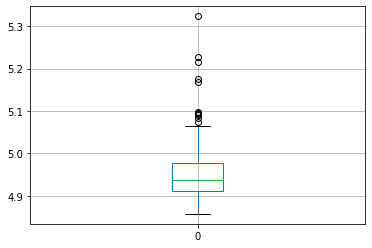

In [107]:
df = pd.DataFrame(traintime['time_elapsed_epoch'])
df.boxplot()
df.describe()

In [113]:
traintime['total_time_elapsed']/60

12.39230793317159

In [110]:
df.sum()

0    743.538363
dtype: float64

,0
count,69.000000
mean,0.004896
std,0.000242
min,0.004674
25%,0.004758
50%,0.004822
75%,0.004915
max,0.005986


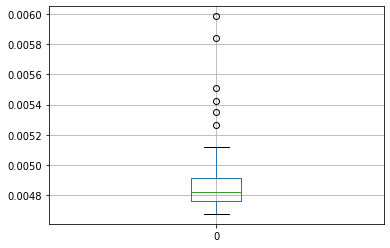

In [112]:
df = pd.DataFrame(traintime['time_elapsed_batch'])
df.boxplot()
df.describe()

def train_time(model, dset_loaders, dset_sizes, criterion, 
               optimizer, dev,  num_epochs = 150):  
    """This function give estimate of training time taken for a specific model
    
    """

    best_model, best_acc = model, 0.0 
    train_losses, val_losses, train_accs = [],[],[]
    val_accs, train_labels, val_labels   = [],[],[]

    # epoch time 
    train_start_time = time.time()
    time_elapsed_epoch = []

    for epoch in range(num_epochs):    
      epoch_start_time = time.time()  

      print('Epoch {}/{}'.format(epoch+1, num_epochs))          
      #### TRAIN PHASE ####
      ypred_labels, ytrue_labels = [], []   
      model.train(True)      
      running_loss, running_corrects = 0.0, 0.0  

      time_elapsed_batch = []     
      #### loop across batches ####
      for batch, datum in enumerate(dset_loaders['train']):          
          # first batch etc 
          inputs, labels = datum # get data 
          optimizer.zero_grad() # zero gradient         

          if not batch % 100:
            print('Processing batch: {} / Data : {}:'.format(batch, inputs.shape))

          batch_start_time = time.time() # record time                 
          preds= model(inputs.to(dev))   # make the prediction      

          loss = criterion(preds, labels.type(torch.LongTensor).to(dev)) # Calculate loss          
          loss.backward() # Backpropogate       
          optimizer.step()# Update the weights          

          time_elapsed_batch.append(time.time() - batch_start_time) # record time

          with torch.no_grad():
              # storch batch training performance 
              running_loss     += float(loss.item())                  
              running_corrects += torch.sum(preds.data.max(1)[1] == labels.data.to(dev))           
              ytrue_labels.append(labels.data.cpu().detach().numpy())
              ypred_labels.append(preds.data.max(1)[1].cpu().detach().numpy())        
              del loss  

      # ********* get the epoch loss and accuracy *********         
      epoch_loss = running_loss / dset_sizes['train']
      epoch_acc  = running_corrects.cpu().numpy()/dset_sizes['train']     

      train_losses.append(epoch_loss)
      train_accs.append(epoch_acc) 
      train_labels.append(dict(ypred = ypred_labels, ytrue = ytrue_labels))                  

      # record each epoch time. 
      time_elapsed_epoch.append(time.time() - epoch_start_time)  

    # record total train time     
    total_time_elapsed = time.time() - train_start_time  

    # save time info
    traintime = dict()
    traintime['filename'] = itemname 
    traintime['time_elapsed_epoch'] = time_elapsed_epoch
    traintime['time_elapsed_batch'] = time_elapsed_batch
    traintime['total_time_elapsed'] = total_time_elapsed
   
    return traintime     

  model.train(False)     
  for batch, vdatum in enumerate(dset_loaders['val']): 
      inputs, labels = vdatum
      if not batch % 10:
        print('Validate batch: {} / Data : {}:'.format(batch, inputs.shape))       

      preds = model(inputs.to(dev))  # predict and calculate the loss         
      loss  = criterion(preds, labels.type(torch.LongTensor).to(dev))               
      
      running_loss     += float(loss.item())                  
      running_corrects += torch.sum(preds.data.max(1)[1] == labels.data.to(dev))           
      ytrue_labels.append(labels.data.cpu().detach().numpy())
      ypred_labels.append(preds.data.max(1)[1].cpu().detach().numpy())              
      del loss     
  vepoch_loss = running_loss / dset_sizes['val'] 
  vepoch_acc  = running_corrects.cpu().numpy()/dset_sizes['val']  

  if  vepoch_acc > best_acc:
      best_acc, best_epoch = vepoch_acc, epoch 
      best_model = copy.deepcopy(model)           

  val_losses.append(vepoch_loss)
  val_accs.append(vepoch_acc) 
  val_labels.append(dict(ypred = ypred_labels, ytrue = ytrue_labels))                  

def get_best_epoch_labels(train_labels, best_epoch):
    """This function is used by train_model to store best epoch labels"""
    import numpy as np
    
    for jj in range(len(train_labels[best_epoch]['ypred'])-1):    
        if jj == 0: 
          ypred = train_labels[best_epoch]['ypred'][jj]              
          ytrue = train_labels[best_epoch]['ytrue'][jj] 
            
        ypred = np.concatenate([ypred, train_labels[best_epoch]['ypred'][jj+1]])
        ytrue = np.concatenate([ytrue, train_labels[best_epoch]['ytrue'][jj+1]])            
    return ypred, ytrue

time_elapsed = time.time() - start_time  

ytrain_best = get_best_epoch_labels(train_labels, best_epoch)
yval_best   = get_best_epoch_labels(val_labels,   best_epoch)      

info = dict(ytrain = ytrain_best, yval = yval_best, 
          best_epoch = best_epoch, best_acc = best_acc)

if verbose > 0:
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, 
                                                      time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc)) 
  print('Best Epoch :', best_epoch+1) 

#return best_model, train_losses, val_losses, train_accs, val_accs, info
